In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from collections import defaultdict

In [2]:
!pip install textblob

In [3]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


# Load the dataset
(Here 'ISO-8859-9' encoding is used to handle common character errors)

In [4]:
try:
    df = pd.read_csv('/content/test.csv', encoding='ISO-8859-1')
except FileNotFoundError:
    print("Error: 'test.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Standardize column names

In [5]:
df.columns = ['Subject', 'body', 'date', 'from_email']

# Convert 'date' to datetime objects. Format is inferred as Day-Month-Year (%d-%m-%Y).

In [6]:
df['Timestamp'] = pd.to_datetime(df['date'], format='%d-%m-%Y', errors='coerce')

# Use the whole email address as the Employee ID

In [7]:
df['EmployeeID'] = df['from_email'].fillna('unknown_user')

# Drop rows where Timestamp could not be parsed or key columns are missing

In [8]:
df.dropna(subset=['Timestamp', 'EmployeeID', 'body'], inplace=True)
df = df.sort_values(by='Timestamp').reset_index(drop=True)

# Concatenate Subject and body for a comprehensive message

In [9]:
df['CombinedMessage'] = df['Subject'].astype(str) + " " + df['body'].astype(str)

# Preprocessing Function
Cleans the message body for reliable keyword matching.

In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'=\d{2}', '', text) # Remove sequences like =20, =01, common in MIME emails
    text = re.sub(r'[\r\n]+', ' ', text) # Replace newlines with spaces
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only letters, numbers, and spaces
    return text.strip()

df['CleanMessage'] = df['CombinedMessage'].apply(clean_text)

print("Data cleaning and preprocessing complete.")

Data cleaning and preprocessing complete.


# Task 1: Sentiment Labeling
Chosen Approach: TextBlob Sentiment Analysis
- TextBlob provides a 'polarity' score ranging from -1.0 (most negative) to +1.0 (most positive).
- Criteria for Sentiment Labeling (Justified and Reproducible):
- Positive: Polarity > 0.1
- Negative: Polarity < -0.1
- Neutral: Polarity between -0.1 and 0.1 (inclusive)

In [11]:
from textblob import TextBlob

def textblob_labeler(text):
    if not text:
        return 'Neutral'
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity

    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['CleanMessage'].apply(textblob_labeler)

print("\n--- Task 1: Sentiment Labeling (TextBlob) Complete ---")


--- Task 1: Sentiment Labeling (TextBlob) Complete ---


# Task 2: Exploratory Data Analysis (EDA)

### 1. Examine Data Structure and Missing Values

In [12]:
df['MessageLength'] = df['CleanMessage'].apply(len)
df['WordCount'] = df['CleanMessage'].apply(lambda x: len(x.split()))
df['Month'] = df['Timestamp'].dt.to_period('M')

print("\n--- Task 2.1: Data Structure ---")
print(f"Number of Records: {len(df)}")
print(f"Data Types:\n{df.dtypes.to_string()}")
print(f"Missing Values:\n{df.isnull().sum().to_string()}")


--- Task 2.1: Data Structure ---
Number of Records: 2191
Data Types:
Subject                    object
body                       object
date                       object
from_email                 object
Timestamp          datetime64[ns]
EmployeeID                 object
CombinedMessage            object
CleanMessage               object
Sentiment                  object
MessageLength               int64
WordCount                   int64
Month                   period[M]
Missing Values:
Subject            0
body               0
date               0
from_email         0
Timestamp          0
EmployeeID         0
CombinedMessage    0
CleanMessage       0
Sentiment          0
MessageLength      0
WordCount          0
Month              0


### 2. Distribution of Sentiment Labels

In [13]:
sentiment_prop = df['Sentiment'].value_counts(normalize=True) * 100
print("\n--- Task 2.2: Sentiment Distribution (%) ---")
print(sentiment_prop.round(2).to_string())


--- Task 2.2: Sentiment Distribution (%) ---
Sentiment
Neutral     46.51
Positive    44.59
Negative     8.90


### 3. Trends Over Time (Monthly Sentiment)

In [14]:
monthly_sentiment_prop = df.groupby('Month')['Sentiment'].value_counts(normalize=True).unstack(fill_value=0)
print("\n--- Task 2.3: Monthly Sentiment Proportion Trend (Head) ---")
print(monthly_sentiment_prop.head().to_string())


--- Task 2.3: Monthly Sentiment Proportion Trend (Head) ---
Sentiment  Negative   Neutral  Positive
Month                                  
2010-01    0.076923  0.527473  0.395604
2010-02    0.076923  0.439560  0.483516
2010-03    0.076923  0.527473  0.395604
2010-04    0.076087  0.543478  0.380435
2010-05    0.054945  0.483516  0.461538


### 4. Additional Patterns (Message Length vs. Sentiment)

In [15]:
length_summary = df.groupby('Sentiment')['MessageLength'].describe().round(2)
print("\n--- Task 2.4: Message Length Summary by Sentiment ---")
print(length_summary.to_string())


--- Task 2.4: Message Length Summary by Sentiment ---
            count    mean     std   min    25%    50%    75%     max
Sentiment                                                           
Negative    195.0  172.13  156.73  10.0   72.0  124.0  183.0   928.0
Neutral    1019.0  222.50  214.30   1.0   65.0  146.0  297.0   974.0
Positive    977.0  326.48  238.56  13.0  144.0  245.0  456.0  1028.0


### Visualization 2.2: Sentiment Distribution

/tmp/ipython-input-2389921681.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_prop.index, y=sentiment_prop.values, palette="rocket", order=['Positive', 'Neutral', 'Negative'])


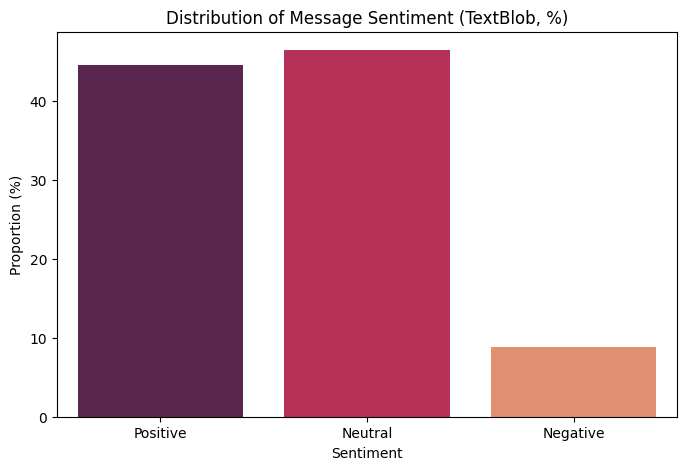

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_prop.index, y=sentiment_prop.values, palette="rocket", order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribution of Message Sentiment (TextBlob, %)')
plt.ylabel('Proportion (%)')
plt.xlabel('Sentiment')
plt.show()



### Visualization 2.3: Monthly Sentiment Trend

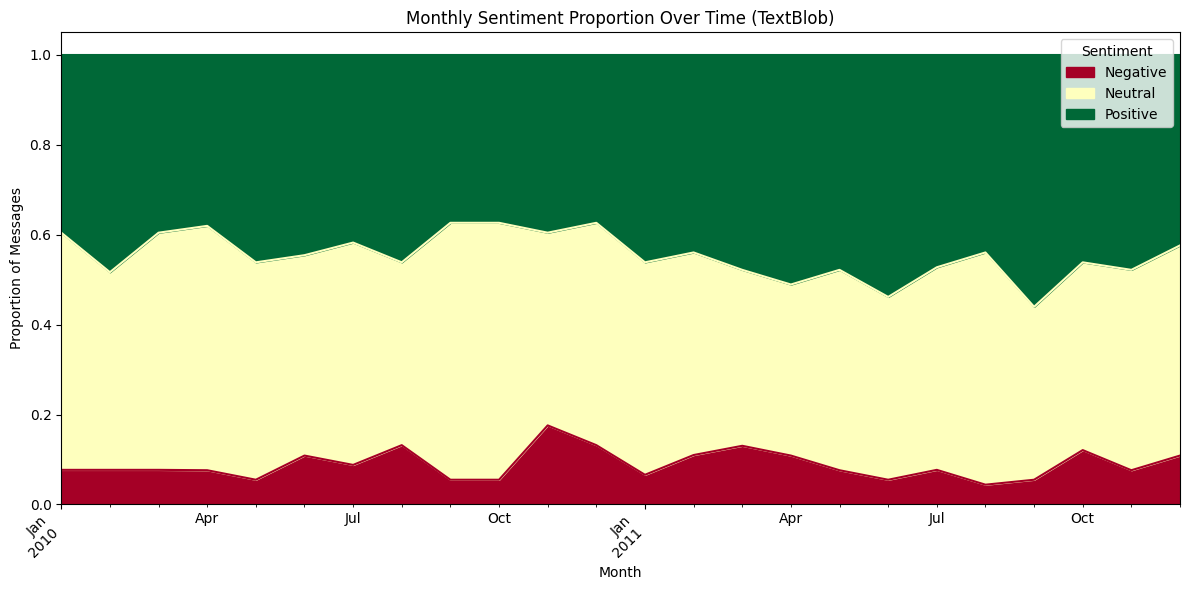

In [23]:
monthly_sentiment_prop.plot(kind='area', stacked=True, figsize=(12, 6), colormap='RdYlGn')
plt.title('Monthly Sentiment Proportion Over Time (TextBlob)')
plt.ylabel('Proportion of Messages')
plt.xlabel('Month')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Task 3: Employee Score Calculation
Scoring Method
- 1. Map Sentiment: Positive=+1, Negative=-1, Neutral=0.
- 2. Group by EmployeeID AND Month, then SUM the scores. The grouping by Month ensures the score resets monthly.

In [25]:
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['MessageScore'] = df['Sentiment'].map(sentiment_map)

# Aggregate scores
monthly_scores = df.groupby(['Month', 'EmployeeID'])['MessageScore'].sum().reset_index()
monthly_scores = monthly_scores.rename(columns={'MessageScore': 'MonthlySentimentScore'})

print("\n--- Task 3: Monthly Sentiment Scores (Sample) ---")
print(monthly_scores.sample(5).to_string())


--- Task 3: Monthly Sentiment Scores (Sample) ---
       Month                EmployeeID  MonthlySentimentScore
156  2011-04   lydia.delgado@enron.com                      5
31   2010-04    don.baughman@enron.com                      5
41   2010-05    don.baughman@enron.com                      9
64   2010-07   johnny.palmer@enron.com                      0
167  2011-05  patti.thompson@enron.com                     -1


# Task 4: Employee Ranking

### 4.1. Sort the scores for robust ranking and tie-breaking
Sorting by: Month (Asc), Score (Desc), EmployeeID (Asc)

In [26]:
ranked_df = monthly_scores.sort_values(
    by=['Month', 'MonthlySentimentScore', 'EmployeeID'],
    ascending=[True, False, True]
).reset_index(drop=True)

### 4.2. Top Three Positive Employees (Highest Scores)

In [27]:
top_positive_employees = ranked_df.groupby('Month').head(3).reset_index(drop=True)
top_positive_employees = top_positive_employees[['Month', 'EmployeeID', 'MonthlySentimentScore']]

### 4.3. Top Three Negative Employees (Lowest Scores)
Sort by Score ascending (lowest is most negative), then by EmployeeID ascending

In [28]:
top_negative_employees = ranked_df.sort_values(
    by=['Month', 'MonthlySentimentScore', 'EmployeeID'],
    ascending=[True, True, True]
).groupby('Month').head(3).reset_index(drop=True)
top_negative_employees = top_negative_employees[['Month', 'EmployeeID', 'MonthlySentimentScore']]

print("\n--- Task 4: Top Three Positive Employees (Head) ---")
print(top_positive_employees.head(5).to_string())
print("\n--- Task 4: Top Three Negative Employees (Head) ---")
print(top_negative_employees.head(5).to_string())


--- Task 4: Top Three Positive Employees (Head) ---
     Month                   EmployeeID  MonthlySentimentScore
0  2010-01     patti.thompson@enron.com                      5
1  2010-01       don.baughman@enron.com                      4
2  2010-01          eric.bass@enron.com                      4
3  2010-02  bobette.riner@ipgdirect.com                      7
4  2010-02        john.arnold@enron.com                      7

--- Task 4: Top Three Negative Employees (Head) ---
     Month                   EmployeeID  MonthlySentimentScore
0  2010-01      rhonda.denton@enron.com                      0
1  2010-01  bobette.riner@ipgdirect.com                      1
2  2010-01        john.arnold@enron.com                      2
3  2010-02      lydia.delgado@enron.com                      1
4  2010-02     patti.thompson@enron.com                      1


In [29]:
# Save rankings
top_positive_employees.to_csv('top_positive_employees.csv', index=False)
top_negative_employees.to_csv('top_negative_employees.csv', index=False)

# Task 5: Flight Risk Identification

### 5.1. Filter for only Negative sentiment messages

In [30]:
negative_df = df[df['Sentiment'] == 'Negative'].copy()
negative_df = negative_df.sort_values(by='Timestamp')

### 5.2. Calculate 30-day rolling count of negative messages for each employee

In [31]:
negative_df['NegativeCount'] = 1

negative_rolling = negative_df.groupby('EmployeeID').rolling(
    window='30D',
    on='Timestamp'
)['NegativeCount'].sum().reset_index()

### 5.3. Identify the flight risk condition (4 or more negative mails in 30 days)

In [32]:
flight_risk_flags = negative_rolling[negative_rolling['NegativeCount'] >= 4]

### 5.4. Extract the unique employees flagged at least once

In [33]:
flight_risk_employees = flight_risk_flags['EmployeeID'].unique()

print("\n--- Task 5: Flight Risk Employees ---")
if len(flight_risk_employees) > 0:
    flight_risk_list_df = pd.DataFrame(flight_risk_employees, columns=['EmployeeID'])
    print(f"Total unique flight risk employees identified: {len(flight_risk_employees)}")
    print(flight_risk_list_df.to_string(index=False))
    flight_risk_list_df.to_csv('flight_risk_employees.csv', index=False)
else:
    print("No employees met the criteria of 4 or more negative messages in a 30-day rolling window.")


--- Task 5: Flight Risk Employees ---
Total unique flight risk employees identified: 6
                 EmployeeID
bobette.riner@ipgdirect.com
    johnny.palmer@enron.com
    lydia.delgado@enron.com
   patti.thompson@enron.com
    rhonda.denton@enron.com
       sally.beck@enron.com


# Task 6: Predictive Modeling (Linear Regression)

### 6.1. Merge Features and Target (Monthly Scores from Task 3)


In [34]:
feature_df = df.groupby(['Month', 'EmployeeID']).agg(
    MonthlyFrequency=('EmployeeID', 'size'),
    AvgMessageLength=('MessageLength', 'mean'),
    AvgWordCount=('WordCount', 'mean')
).reset_index()

model_data = pd.merge(monthly_scores, feature_df, on=['Month', 'EmployeeID'])

### 6.2. Prepare X (Features) and y (Target)

In [35]:
X = model_data[['EmployeeID', 'MonthlyFrequency', 'AvgMessageLength', 'AvgWordCount']]
y = model_data['MonthlySentimentScore']
# Handle EmployeeID (Categorical Feature)
X = pd.get_dummies(X, columns=['EmployeeID'], drop_first=True)

### 6.3. Split data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6.4. Develop a Linear Regression Model

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 6.5. Validate Model Effectiveness

In [38]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Task 6: Linear Regression Model Evaluation ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2) Score: {r2:.2f}")


--- Task 6: Linear Regression Model Evaluation ---
Mean Squared Error (MSE): 2.64
R-squared (R2) Score: 0.67


### 6.6. Interpret Model Results

In [39]:
coefficients_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("\n--- Task 6: Model Coefficients ---")
print("Interpretation: A positive coefficient means that feature increases the Monthly Sentiment Score.")
print(coefficients_df.to_string(index=False))


--- Task 6: Model Coefficients ---
Interpretation: A positive coefficient means that feature increases the Monthly Sentiment Score.
                            Feature  Coefficient
    EmployeeID_sally.beck@enron.com     0.876044
 EmployeeID_johnny.palmer@enron.com     0.710951
   EmployeeID_john.arnold@enron.com     0.621488
 EmployeeID_lydia.delgado@enron.com     0.580717
     EmployeeID_eric.bass@enron.com     0.497420
  EmployeeID_don.baughman@enron.com     0.447974
 EmployeeID_kayne.coulter@enron.com     0.416213
                   MonthlyFrequency     0.307120
                       AvgWordCount     0.009383
                   AvgMessageLength     0.001206
EmployeeID_patti.thompson@enron.com    -0.091359
 EmployeeID_rhonda.denton@enron.com    -0.160192


### Visualization: Actual vs. Predicted

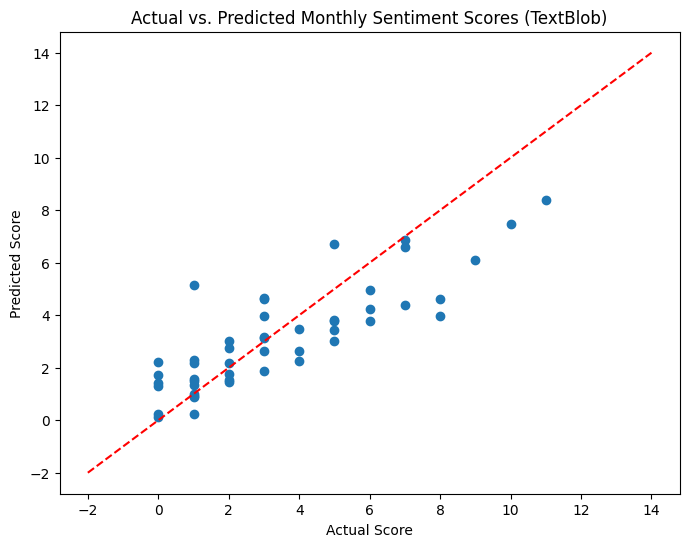

In [41]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Actual vs. Predicted Monthly Sentiment Scores (TextBlob)')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.show()